In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def plot_importances(columns,importances,figsize=None, ax=None):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    I.plot(kind='barh', figsize=figsize, legend=False, ax=ax, fontsize=14)

In [35]:
df = pd.read_csv("data/rent.csv", parse_dates=['created'])
features = ['bathrooms','bedrooms','price','longitude','latitude',
            'interest_level']
#df = df[features].head(20).copy()
df = df[features].copy()
df.to_csv("data/rent-numeric.csv", index=False)
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
df.head(5)

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


# Built-in scikit importances

0.717964824121
0.713284162749


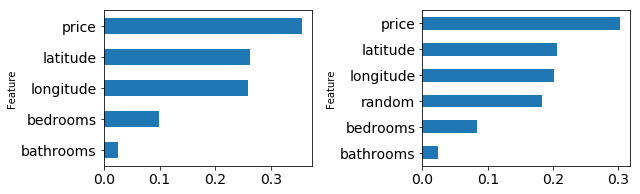

In [57]:
base_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=5,
                                 n_jobs=-1,
                                 oob_score=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']

rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)
plot_importances(X_train.columns,rf.feature_importances_, ax=axes[0])

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train2))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
print(rf2.oob_score_)
plot_importances(X_train2.columns,rf2.feature_importances_, ax=axes[1])

plt.tight_layout()
plt.show()

# Importances via dropping columns and retraining

In [58]:
from sklearn.base import clone

def classifier_dropping_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf.random_state = 999
    rf_.fit(X_train, y_train)
    oob = rf_.oob_score_
    print(f"oob accuracy is {oob} for {X_train.columns.values}")
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
#         print(f"{col:10s}: accuracy {oob:5.4f} - {o:5.4f} = {oob - o:5.4f}")
        imp.append(oob - o)
    return np.array(imp)

def classifier_dropping_importances_cv(rf, X_train, y_train, k=5):
    rf_ = clone(rf)
    rf.random_state = 999
    rf_.fit(X_train, y_train)
    
    cvscore = cross_val_score(clone(rf), X_train, y_train, cv=k, scoring='accuracy')
    m_base = cvscore.mean()
    print(f"{k}-fold cross-validation accuracy {m_base:.4f}")
                              
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        
        cvscore = cross_val_score(clone(rf_), X, y_train, cv=5, scoring='accuracy')
        m = cvscore.mean()
        print(f"drop {col} {k}-fold cross-validation accuracy {m:.4f}")
        imp.append(m_base - m)
        
    return np.array(imp)

oob accuracy is 0.7168909061436214 for ['bathrooms' 'bedrooms' 'price' 'longitude' 'latitude']
oob accuracy is 0.7143986059328903 for ['bathrooms' 'bedrooms' 'price' 'longitude' 'latitude' 'random']


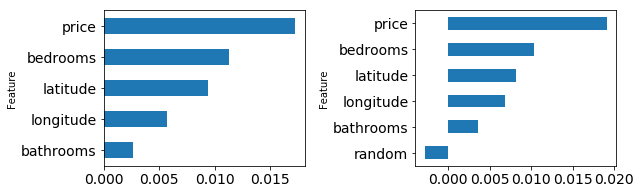

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

# max_features=n_features for regressors but sqrt for classifiers

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
rf = clone(base_rf)
plot_importances(X_train.columns, 
                 classifier_dropping_importances(rf, X_train, y_train), ax=axes[0])

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
plot_importances(X_train2.columns,
                 classifier_dropping_importances(rf2, X_train2, y_train), ax=axes[1])

plt.tight_layout()
plt.show()

# Importances via column perturbation

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices

# TODO: add arg for subsample size to compute oob score

def oob_classifier_accuracy(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

def classifier_permutation_importances(rf, X_train, y_train):
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        o = oob_classifier_accuracy(rf, X_train, y_train)
        X_train[col] = save
#         print(col,o,'=>',oob - o)
        imp.append(oob - o)
    return np.array(imp)

oob accuracy 0.71620197763


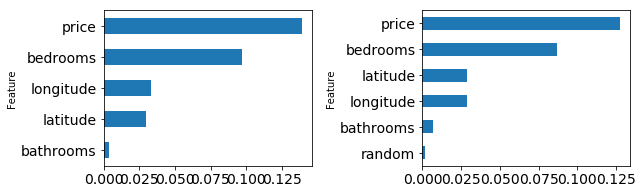

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
rf = clone(base_rf)
rf.fit(X_train, y_train)
oob = oob_classifier_accuracy(rf, X_train, y_train)
print("oob accuracy",oob)

plot_importances(X_train.columns, 
                 classifier_permutation_importances(rf, X_train, y_train), ax=axes[0])

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

plot_importances(X_train2.columns,
                 classifier_permutation_importances(rf2, X_train2, y_train), ax=axes[1])

plt.tight_layout()
plt.show()

## Play

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

random_state = 999

df = pd.read_csv("data/rent.csv", parse_dates=['created'])
features = ['bathrooms','bedrooms','price','longitude','latitude',
            'interest_level']
df = df[features].copy()
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
#df['random'] = np.random.randint(0,10,size=len(df))

df_train, df_test = train_test_split(df, test_size=0.20)

X_train, y_train = df_train.drop('interest_level',axis=1).copy(), df_train['interest_level'].copy()
X_test, y_test = df_test.drop('interest_level',axis=1).copy(), df_test['interest_level'].copy()

rf = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
rf.fit(X_train, y_train)
oob = rf.oob_score_
my_oob = oob_classifier_accuracy(rf, X_train, y_train)
accur = accuracy_score(y_test, rf.predict(X_test))
logloss = log_loss(y_test, rf.predict_proba(X_test))
print(f"Base accuracy OOB {oob:5.5f} valid {accur:5.5f} valid log loss {logloss:5.5f}")
print(f"My oob {my_oob:.5f}")

print()

# rf_ = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
# rf_.fit(X_train, y_train)
# print(f"train clone; accuracy is {rf_.oob_score_:5.5f}")

rf_ = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
rf_.fit(X_train.drop('price',axis=1), y_train)
my_oob = oob_classifier_accuracy(rf_, X_train.drop('price',axis=1), y_train)
print(f"drop price my oob {my_oob:.5f}")
accur_ = accuracy_score(y_test, rf_.predict(X_test.drop('price',axis=1)))
logloss_ = log_loss(y_test, rf_.predict_proba(X_test.drop('price',axis=1)))
print(f"drop price {accur:5.5f} - {accur_:5.5f} = {accur - accur_:5.5f}")
print(f"drop price |{logloss:5.5f} - {logloss_:5.5f}| = {np.abs(logloss - logloss_):5.5f}")
print(f"drop price {oob:5.5f} - {rf_.oob_score_:5.5f} = {oob - rf_.oob_score_:5.5f}\n")

rf_ = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
rf_.fit(X_train.drop('bedrooms',axis=1), y_train)
my_oob = oob_classifier_accuracy(rf_, X_train.drop('bedrooms',axis=1), y_train)
print(f"drop bedrooms my oob {my_oob:.5f}")
accur_ = accuracy_score(y_test, rf_.predict(X_test.drop('bedrooms',axis=1)))
logloss_ = log_loss(y_test, rf_.predict_proba(X_test.drop('bedrooms',axis=1)))
print(f"drop bedrooms {accur:5.5f} - {accur_:5.5f} = {accur - accur_:5.5f}")
print(f"drop bedrooms |{logloss:5.5f} - {logloss_:5.5f}| = {np.abs(logloss - logloss_):5.5f}")
print(f"drop bedrooms {oob:5.5f} - {rf_.oob_score_:5.5f} = {oob - rf_.oob_score_:5.5f}\n")

rf_ = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
rf_.fit(X_train.drop('bathrooms',axis=1), y_train)
my_oob = oob_classifier_accuracy(rf_, X_train.drop('bathrooms',axis=1), y_train)
print(f"drop bathrooms my oob {my_oob:.5f}")
accur_ = accuracy_score(y_test, rf_.predict(X_test.drop('bathrooms',axis=1)))
logloss_ = log_loss(y_test, rf_.predict_proba(X_test.drop('bathrooms',axis=1)))
print(f"drop bathrooms {accur:5.5f} - {accur_:5.5f} = {accur - accur_:5.5f}")
print(f"drop bathrooms |{logloss:5.5f} - {logloss_:5.5f}| = {np.abs(logloss - logloss_):5.5f}")
print(f"drop bathrooms {oob:5.5f} - {rf_.oob_score_:5.5f} = {oob - rf_.oob_score_:5.5f}\n")

rf_ = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True, random_state=random_state)
rf_.fit(X_train.drop('latitude',axis=1), y_train)
my_oob = oob_classifier_accuracy(rf_, X_train.drop('latitude',axis=1), y_train)
print(f"drop latitude my oob {my_oob:.5f}")
accur_ = accuracy_score(y_test, rf_.predict(X_test.drop('latitude',axis=1)))
logloss_ = log_loss(y_test, rf_.predict_proba(X_test.drop('latitude',axis=1)))
print(f"drop latitude {accur:5.5f} - {accur_:5.5f} = {accur - accur_:5.5f}")
print(f"drop latitude |{logloss:5.5f} - {logloss_:5.5f}| = {np.abs(logloss - logloss_):5.5f}")
print(f"drop latitude {oob:5.5f} - {rf_.oob_score_:5.5f} = {oob - rf_.oob_score_:5.5f}")